### File containing the functionalities of our bayesian model draft

## I. Prerequesites

**1. Import Packages**

In [59]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import CRPS.CRPS as pscore
from data_gathering import gather_data_actuals, gather_data_features
from mappings import import_country_mapping
from sklearn.model_selection import TimeSeriesSplit

**2. Define functions**

In [60]:
def standardize(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize a pandas DataFrame"""
    standardized_df = pd.DataFrame()
    for column in df.columns:
        standardized_column = (df[column] - df[column].mean()) / df[column].std()
        standardized_df[column] = standardized_column
    return standardized_df

def standardize_series(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

def take_logarithm(df: pd.DataFrame) -> pd.DataFrame:
    """take logarithm a pandas DataFrame"""
    logarithmized_df = pd.DataFrame()
    for column in df.columns:
        logarithmized_column = np.log(df[column])
        logarithmized_df[column] = logarithmized_column
    return logarithmized_df

def calculate_crps(idata: az.InferenceData, actuals: pd.DataFrame) -> (pd.DataFrame, float):
    """
    Calculate the Continuous Ranked Probability Score (CRPS) for each observation and the average CRPS.

    Parameters:
        idata (az.InferenceData): InferenceData object containing the posterior predictive.
        actuals (pd.DataFrame): DataFrame containing the observed data. Each row corresponds to an observation.

    Returns:
        crps_scores (pd.DataFrame): A Series containing the CRPS score for each observation.
        average_crps (float): The average CRPS score across all observations.
    """
    try:
        # Access the posterior predictive samples for each observation
        posterior_samples = idata['posterior_predictive']['obs'].values
    except KeyError:
        raise KeyError("The InferenceData object does not contain posterior predictive samples.")

    # Reshape the array to a 2D array with samples in rows and observations in columns
    num_chains, num_draws, num_observations = posterior_samples.shape
    reshaped_samples = posterior_samples.reshape(num_chains * num_draws, num_observations)

    # Convert the 2D array to a pandas DataFrame
    df_posterior_samples = pd.DataFrame(reshaped_samples)

    # Optionally, you can add meaningful column names to the DataFrame
    # For example, assuming the original DataFrame has column names 'obs_0', 'obs_1', etc.
    column_names = ['obs_{}'.format(column_idx) for column_idx in range(num_observations)]
    df_posterior_samples.columns = column_names

    # List to store the CRPS scores for each observation
    crps_scores = []

    # Iterate over each column (observation) in the DataFrame
    for col in df_posterior_samples.columns:
        # Get the observation index from the column name
        obs_idx = int(col.split("_")[1])
        observed_values = actuals.ged_sb.iloc[obs_idx]  # Assuming actuals DataFrame has the observed values
        predictive_samples = df_posterior_samples[col]
        predictive_samples = np.array(predictive_samples)

        # Compute CRPS for the current observation
        crps, _, _ = pscore(predictive_samples, observed_values).compute()
        crps_scores.append(crps)

    # Average CRPS across all observations
    average_crps = np.mean(crps_scores)

    return pd.DataFrame(crps_scores), average_crps

In [ ]:
def model_training(df:pd.DataFrame, model_params: dict, validation_year: int, K:int)->:
    # Extracting year and month from month_id
    df['year'] = ((df['month_id'] - 1) // 12) + 1990
    df['month'] = ((df['month_id'] - 1) % 12) + 1

    # Step 1: Split data into training and test sets
    train_data = df[(df['year'] >= 1990) & (df['year'] < 2018)]
    test_data = df[df['year'] == 2018]

    # Step 2: Perform "10-Fold" time series cross-validation within the training set with a 2-month-gap
    tscv = TimeSeriesSplit(n_splits=K)

    for train_index, val_index in tscv.split(train_data):
        # Extract train and validation sets for the current fold
        train_fold = train_data.iloc[train_index]
        val_fold = train_data.iloc[val_index]

        # Exclude last two months (November and December) from the training set
        train_fold = train_fold[~((train_fold['month'] == 11) | (train_fold['month'] == 12))]

        # Step 3: Train the model on the training set
        model, trace = build_bayesian_model(df, model_params)

        # Step 4: Predict the validation set
        crps_scores, crps_average = calculate_crps(trace, val_fold)



In [ ]:
model_params = {
    "coords": COORDS,
    "intercept_prior_sigma": 0.1,
    "slopes_prior_mu": 0.0,
    "slopes_prior_sd": 10,
    "alpha_prior_alpha": 0.1,
    "alpha_prior_beta": 0.1,
    "regressors_data": [df.ged_sb_tlag_1.to_numpy(), df.ged_sb_tsum_24.to_numpy()],  # Add more predictors' data as needed
    "Y_data": df.ged_sb.to_numpy(),
    "regularization_param": 0.01,  # Add your desired regularization parameter value
    "num_knots": 10,  # Add your desired number of knots for P-splines
    "draws": 1000,
    "tune": 2000,
    "random_seed": rng,
    "target_accept": 0.95
}


In [ ]:
# Note: Written by GitHub Copilot, not done yet
def build_bayesian_model(df: pd.DataFrame(), model_params: dict):
    """
    Build the Bayesian model for the negative binomial regression with P-splines.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        model_params (dict): Dictionary containing the model parameters.

    Returns:
        model: PyMC3 model object
        trace: PyMC3 trace object
    """
    # Extract the model parameters
    coords = model_params["coords"]
    intercept_prior_sigma = model_params["intercept_prior_sigma"]
    slopes_prior_mu = model_params["slopes_prior_mu"]
    slopes_prior_sd = model_params["slopes_prior_sd"]
    alpha_prior_alpha = model_params["alpha_prior_alpha"]
    alpha_prior_beta = model_params["alpha_prior_beta"]
    regressors_data = model_params["regressors_data"]
    Y_data = model_params["Y_data"]
    regularization_param = model_params["regularization_param"]
    num_knots = model_params["num_knots"]
    draws = model_params["draws"]
    tune = model_params["tune"]
    random_seed = model_params["random_seed"]
    target_accept = model_params["target_accept"]

    # Build the model
    with pm.Model(coords=coords) as bayesian_model_nb:
        # Define the priors for the intercept, slopes, and over-dispersion parameter
        intercept = pm.Normal("intercept", 0.0, intercept_prior_sigma)
        slopes = pm.Normal("slopes", slopes_prior_mu, slopes_prior_sd, dims="predictors")
        alpha = pm.Gamma('alpha', alpha_prior_alpha, alpha_prior_beta)

        # Specify the data
        X = []
        for i in range(len(regressors_data)):
            X.append(pm.ConstantData("X{}".format(i), regressors_data[i], dims="obs_idx"))
        Y = pm.ConstantData("Y", Y_data, dims="obs_idx")

        # Define the basis functions
        knots = np.linspace(df['month_id'].min(), df['month_id'].max(), num_knots + 2)[1:-1]
        basis_funcs = pm.spline.make_spline_basis(knots, degree=3)

        # Define the coefficients for the basis functions
        beta = pm.Normal("beta", mu=0, sigma=regularization_param, dims="basis_funcs")

        # Define the mean of the negative binomial distribution
        mu = pm.math.exp(intercept + pm.math.dot(X, slopes) + pm.math.dot(basis_funcs, beta))

        # Define the likelihood
        obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

        # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
        trace = pm.sample(draws=draws, tune=tune, random_seed=random_seed, target_accept=target_accept)

        return bayesian_model_nb, trace



In [ ]:
def add_year_column(df: pd.DataFrame) -> pd.DataFrame:
    # Extracting year from month_id by dividing by 12 and adding the base year 1990
    df['year'] = ((df['month_id'] - 1) // 12) + 1990
    return df

**3. Set style and generate random seed**

In [61]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

## II. Data Preparation

 **1. Load data**

In [62]:
data_cm_actual_2018, data_cm_actual_2019, data_cm_actual_2020, data_cm_actual_2021, data_cm_actual_allyears \
    = gather_data_actuals()
# Load features data
data_cm_features_2017, data_cm_features_2018, data_cm_features_2019, data_cm_features_2020, data_cm_features_allyears \
    = gather_data_features()

In [117]:
predictors = ['ged_sb_tlag_1', 'ged_sb_tsum_24']
target_variable = ['ged_sb']
country_mapping = import_country_mapping()
country = 'Syria'
country_id = country_mapping.loc[country_mapping['name'] == country, 'country_id'].iloc[0]

In [118]:
X = data_cm_features_allyears.loc[data_cm_features_allyears['country_id'] == country_id, predictors]
y = data_cm_features_allyears.loc[data_cm_features_allyears['country_id'] == country_id, target_variable]
X = X.reset_index(drop=True, inplace=False)
y = y.reset_index(drop=True, inplace=False)

**2. Standardize data and/or take loagrithm of data**

In [119]:
# Standardize target variable y
y_std = standardize(y)

# Calculate the standardized logarithm of input data X
X_std= standardize(X)
X_std_log = take_logarithm(X_std)

C:\Users\Uwe Drauz\anaconda3\envs\bachelor_thesis_pymc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Uwe Drauz\anaconda3\envs\bachelor_thesis_pymc\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


**3. Create data frames with standardized and/or logarithmized data**

In [120]:
# Create data frame with target variable and standardized input data
df_Y_non_std_X_std = pd.concat([y, X_std], axis=1)
# Create data frame with standardized target variable and standardized input data
df_Y_std_X_Std = pd.concat([y_std, X_std], axis=1)
# Create data frame with target variable and standardized logarithm of input data
df_Y_non_std_X_std_log = pd.concat([y, X_std_log], axis=1)
# Create data frame with standardized target variable and standardized logarithm of input data
df_Y_std_X_std_log = pd.concat([y_std, X_std_log], axis=1)

**4. Define which data to use**

In [121]:
df = df_Y_non_std_X_std

## III. Model Building

In [122]:
# Define dictionary for implicit handling of data
COORDS = {"predictors": ['ged_sb_tlag_1', 'ged_sb_tsum_24'], "obs_idx": df.index}

**1. Build Bayesian model with Gaussian distribution**

In [69]:
with pm.Model(coords=COORDS) as bayesian_model_gauss:
    # Define the priors for regressors and standard deviation
    intercept = pm.Normal('intercept', 0.0, 1.0)
    beta = pm.Normal("slopes", 0.0, 1.0, dims="predictors")
    sigma = pm.HalfNormal("sigma", 25)

    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", df.ged_sb_tlag_1.to_numpy(), dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", df.ged_sb_tsum_24.to_numpy(), dims="obs_idx")
    Y = pm.ConstantData("fatility count", df.ged_sb.to_numpy(), dims="obs_idx")

    # Specify mean of gaussian distribution
    mu = intercept +  beta[0] * X1 + beta[1] * X2
    # mean for target variable
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=Y, dims="obs_idx")

    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_gauss = pm.sample(1000, tune=2000, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 35 seconds.


In [70]:
with bayesian_model_gauss:
    ppc_prior_gauss = pm.sample_prior_predictive(samples=500, random_seed=rng)
    ppc_posterior_gauss = pm.sample_posterior_predictive(idata_bayesian_gauss, extend_inferencedata=True, random_seed=rng)

Sampling: [intercept, obs, sigma, slopes]
Sampling: [obs]


**2. Build Bayesian model with Negative Binomial distribution (alpha HalfNormal distributed)**

In [71]:
# Build the model
with pm.Model(coords=COORDS) as bayesian_model_nb:
    # Define the priors for regressors and  negative binomial over-dispersion parameter
    intercept = pm.HalfNormal("intercept", sigma=0.1)
    beta = pm.Normal("slopes", 0.0, 10, dims="predictors")
    alpha = pm.HalfNormal('alpha', 2.5)

    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", df.ged_sb_tlag_1.to_numpy(), dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", df.ged_sb_tsum_24.to_numpy(), dims="obs_idx")
    Y = pm.ConstantData("fatility count", df.ged_sb.to_numpy(), dims="obs_idx")

    # Note: Possibly an option to change to pm.Deterministic
    # Define mean of negative binomial distribution
    mu = pm.math.exp(intercept + beta[0] * X1 + beta[1] * X2)

    # Define the likelihood
    obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

    # Note: Optionally define cores and chains
    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_nb = pm.sample(draws=1000, tune=2000, random_seed=rng, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 41 seconds.


In [72]:
try:
    with bayesian_model_nb:
        ppc_posterior_nb = pm.sample_posterior_predictive(idata_bayesian_nb, extend_inferencedata=True, random_seed=rng)
except Exception as error:
    print("Error", error)

Sampling: [obs]


In [73]:
try:
    with bayesian_model_nb:
        ppc_prior_nb = pm.sample_prior_predictive(samples=500, random_seed=rng)
except Exception as error:
    print("Error", error)


Sampling: [alpha, intercept, obs, slopes]


Error n too large or p too small, see Generator.negative_binomial Notes
Apply node that caused the error: nbinom_rv{0, (0, 0), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x235706D8900>), [370], 4, alpha, Composite{(i5 / (exp((i2 + (i3 * i4) + (i0 * i1))) + i5))}.0)
Toposort index: 10
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=(370,))]
Inputs shapes: ['No shapes', (1,), (), (), (370,)]
Inputs strides: ['No strides', (8,), (), (), (8,)]
Inputs values: [Generator(PCG64) at 0x235706D8900, array([370], dtype=int64), array(4, dtype=int64), array(2.84615862), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disable

**3. Build Bayesian model with Negative Binomial distribution (alpha Gamma distributed)**

In [123]:
# Build the model
with pm.Model(coords=COORDS) as bayesian_model_nb_gamma:
    # Define the priors for regressors and  negative binomial over-dispersion parameter
    intercept = pm.HalfNormal("intercept", sigma=0.1)
    beta = pm.Normal("slopes", 0.0, 10, dims="predictors")
    alpha = pm.Gamma('alpha', 0.1, 0.1)

    # Specify the data
    X1 = pm.ConstantData("fatality lag t=1", df.ged_sb_tlag_1.to_numpy(), dims="obs_idx")
    X2 = pm.ConstantData("fatality rolling average t=24", df.ged_sb_tsum_24.to_numpy(), dims="obs_idx")
    Y = pm.ConstantData("fatility count", df.ged_sb.to_numpy(), dims="obs_idx")

    # Note: Possibly an option to change to pm.Deterministic
    # Define mean of negative binomial distribution
    mu = pm.math.exp(intercept + beta[0] * X1 + beta[1] * X2)

    # Define the likelihood
    obs = pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=Y, dims="obs_idx")

    # Note: Optionally define cores and chains
    # Run the sampling using the No-U-Turn Sampler (NUTS) for the specified number of samples
    idata_bayesian_nb_gamma = pm.sample(draws=1000, tune=2000, random_seed=rng, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 43 seconds.


In [124]:
try:
    with bayesian_model_nb_gamma:
        ppc_posterior_nb_gamma = pm.sample_posterior_predictive(idata_bayesian_nb_gamma, extend_inferencedata=True, random_seed=rng)
except Exception as error:
    print("Error", error)

Sampling: [obs]


In [125]:
try:
    with bayesian_model_nb_gamma:
        ppc_prior_nb_gamma = pm.sample_prior_predictive(samples=500, random_seed=rng)
except Exception as error:
    print("Error", error)

Sampling: [alpha, intercept, obs, slopes]


Error n too large or p too small, see Generator.negative_binomial Notes
Apply node that caused the error: nbinom_rv{0, (0, 0), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x235033292A0>), [370], 4, alpha, Composite{(i5 / (exp((i2 + (i3 * i4) + (i0 * i1))) + i5))}.0)
Toposort index: 10
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=(370,))]
Inputs shapes: ['No shapes', (1,), (), (), (370,)]
Inputs strides: ['No strides', (8,), (), (), (8,)]
Inputs values: [Generator(PCG64) at 0x235033292A0, array([370], dtype=int64), array(4, dtype=int64), array(9.70309951), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disable

## IV. Model Evaluation

**tbd: what exactly do we examine here?**

### Model with negative binomial distribution for likelihood (alpha half normal distributed)

In [77]:
# Specify which model should be examined
model = bayesian_model_nb
idata = idata_bayesian_nb

**Visualisations**

<Axes: title={'center': 'alpha'}>

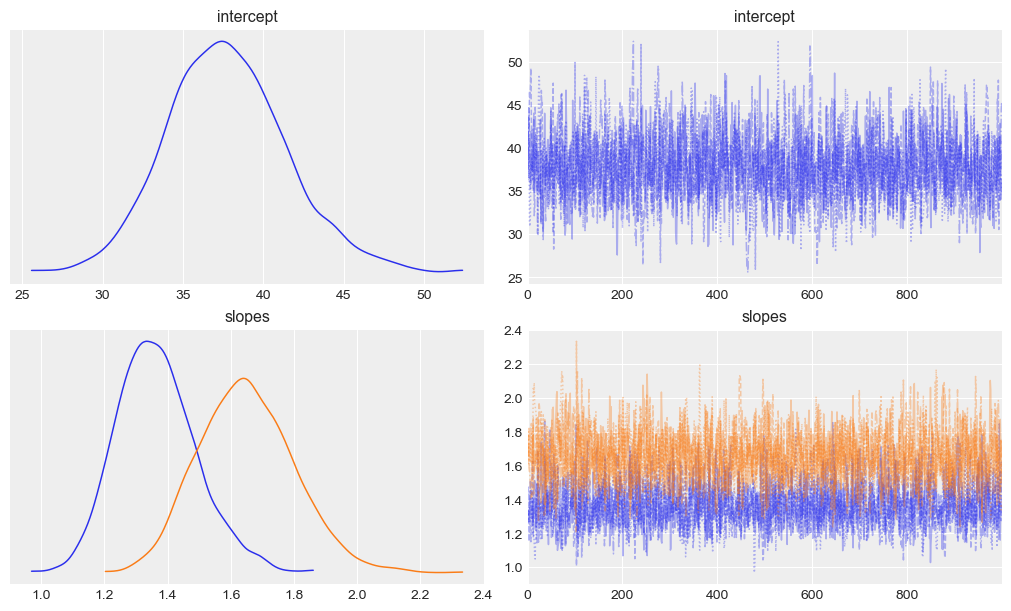

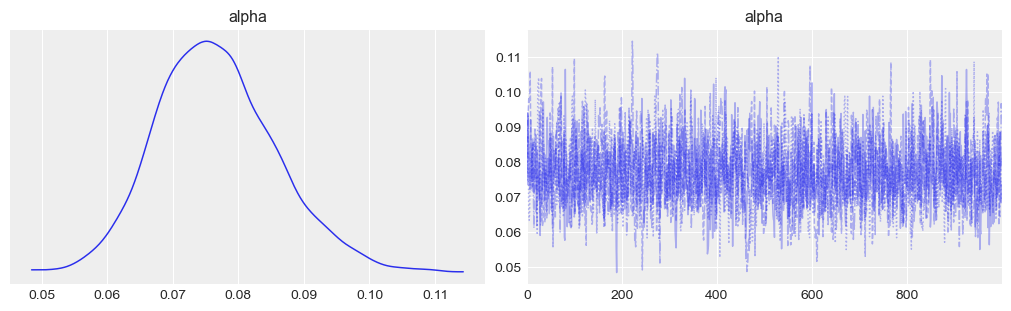

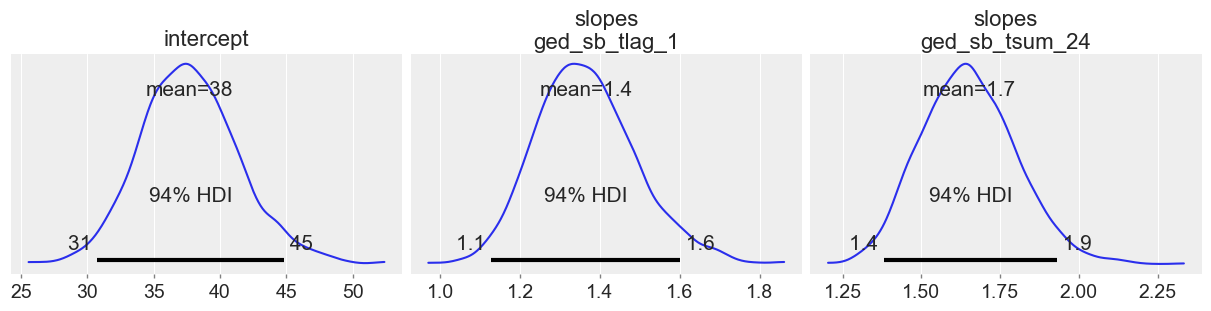

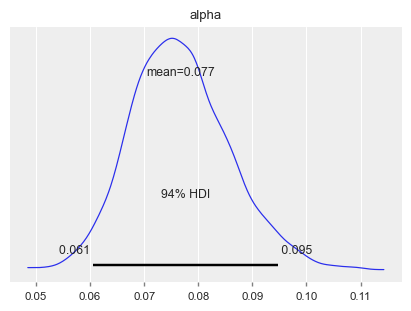

In [78]:
# Plotting trace with parameters transformed back to original scale
# Plotting trace plots with appropriate size
az.plot_trace(np.exp(idata.posterior), var_names=["intercept", "slopes"], combined=True, figsize=(10, 6))
az.plot_trace(idata.posterior, var_names=["alpha"], combined=True, figsize=(10, 3))

# Plotting posterior plots with appropriate size
az.plot_posterior(np.exp(idata.posterior), var_names=["intercept", "slopes"], figsize=(12, 3))
az.plot_posterior(idata, var_names=["alpha"], figsize=(4, 3))


array([<Axes: title={'center': 'slopes\nged_sb_tlag_1'}>,
       <Axes: title={'center': 'slopes\nged_sb_tsum_24'}>,
       <Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'alpha'}>], dtype=object)

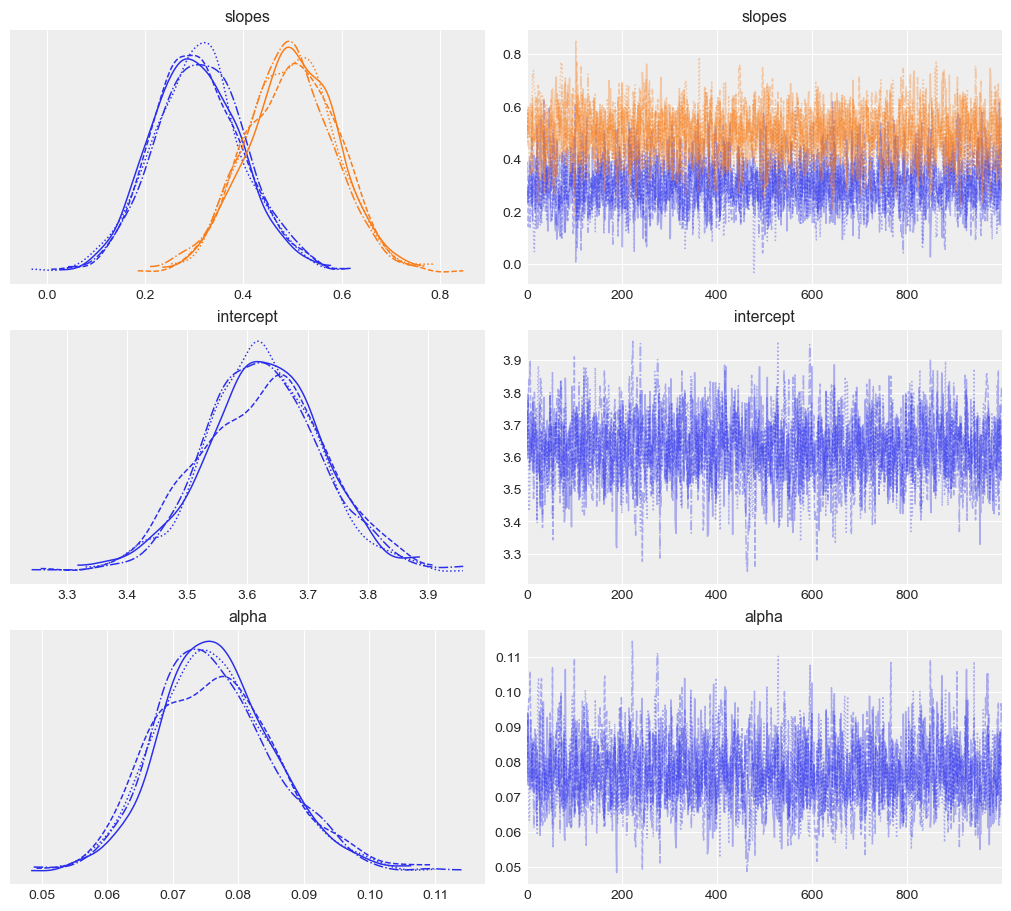

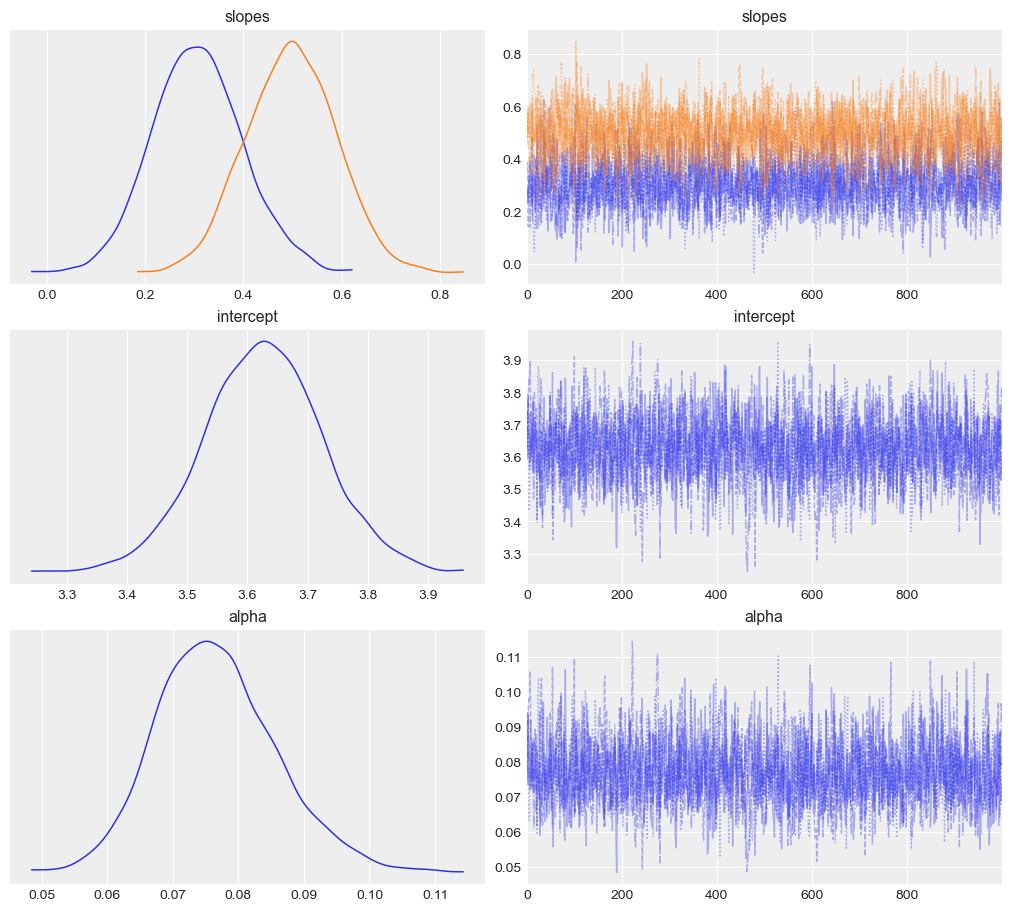

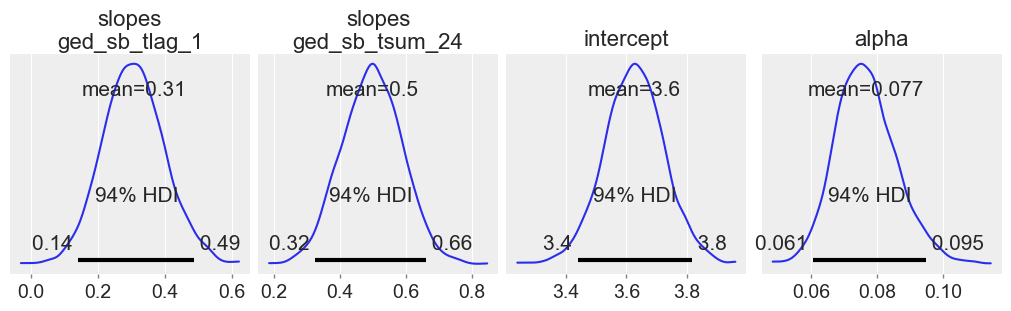

In [79]:
# Plotting trace plots in logaritmic scale
az.plot_trace(idata, figsize=(10, 9))
az.plot_trace(idata, combined=True, figsize=(10, 9))
az.plot_posterior(idata, figsize=(10, 3))

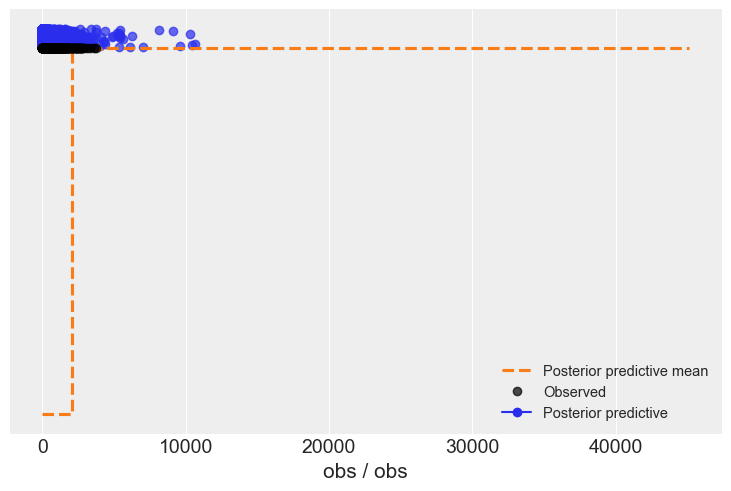

In [80]:
try:
    az.plot_ppc(idata, num_pp_samples=50, kind="scatter")
except Exception as error:
    print("Error", error)

**Summary Statistics**

In [132]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior), kind="stats", var_names=["intercept", "slopes"])

mean     sd  hdi_3%  hdi_97%
intercept                2.829  0.269   2.365    3.364
slopes[ged_sb_tlag_1]   13.214  4.373   6.398   21.198
slopes[ged_sb_tsum_24]   3.632  0.644   2.503    4.889

In [133]:
az.summary(idata.posterior, kind="stats", var_names=["alpha"])

mean     sd  hdi_3%  hdi_97%
alpha  0.008  0.001   0.006     0.01

**CRPS evaluation**

In [85]:
# Calculate CRPS for posterior predictive
crps_nb, crps_average_nb = calculate_crps(idata, actuals=y)

### Model with negative binomial distribution for likelihood (alpha Gamma distributed)

In [126]:
# Specify which model should be examined
model = bayesian_model_nb_gamma
idata = idata_bayesian_nb_gamma

**Visualisations**

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

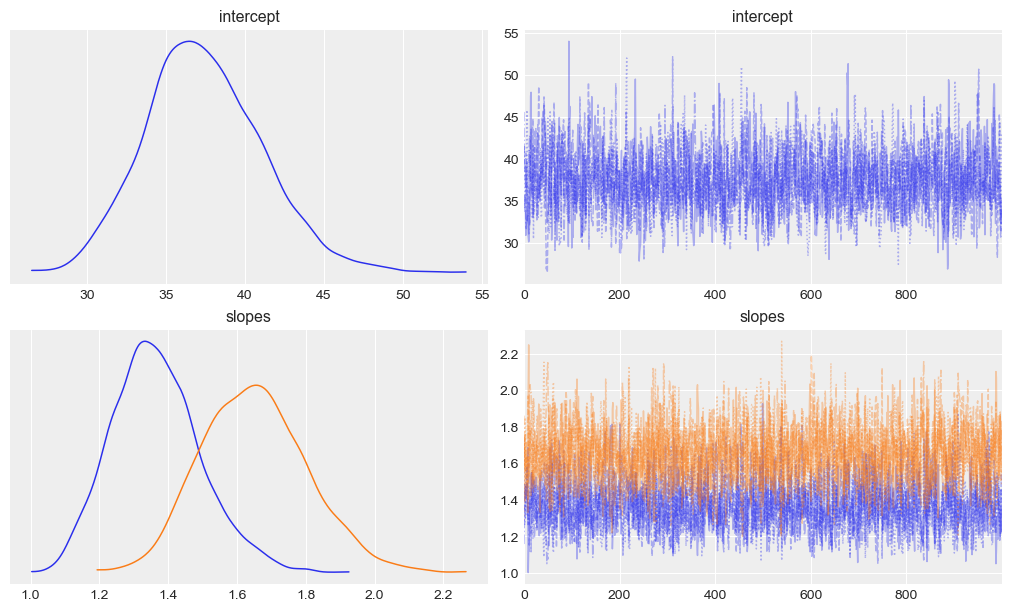

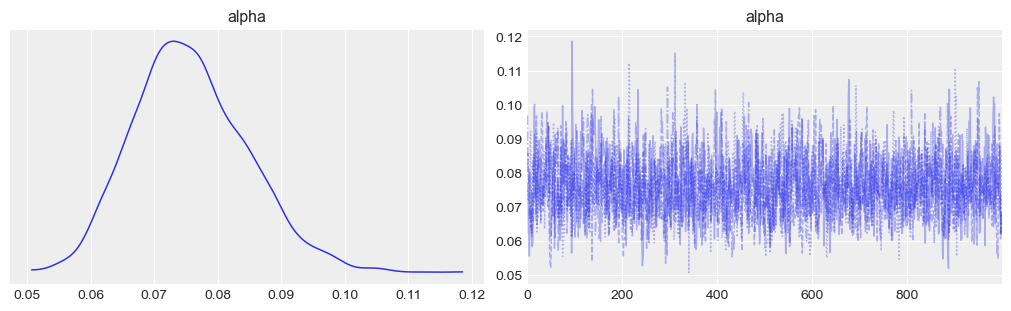

In [87]:
# Plotting trace with parameters transformed back to original scale
# Plotting trace plots with appropriate size
az.plot_trace(np.exp(idata.posterior), var_names=["intercept", "slopes"], combined=True, figsize=(10, 6))
az.plot_trace(idata.posterior, var_names=["alpha"], combined=True, figsize=(10, 3))

<Axes: title={'center': 'alpha'}>

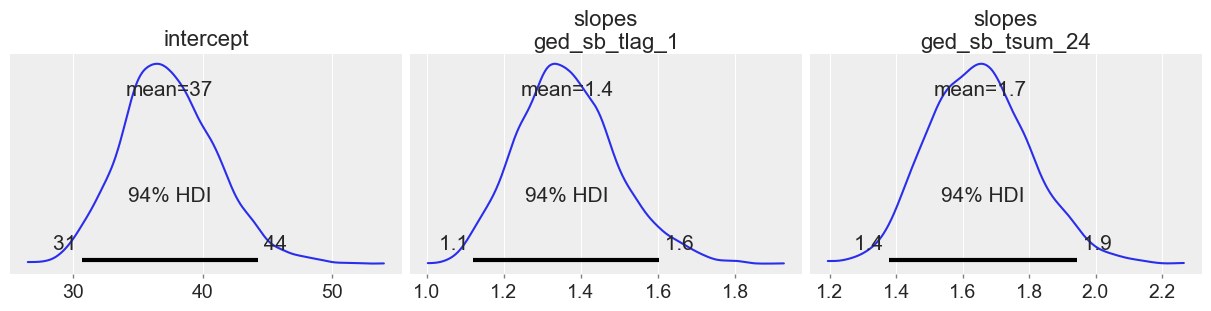

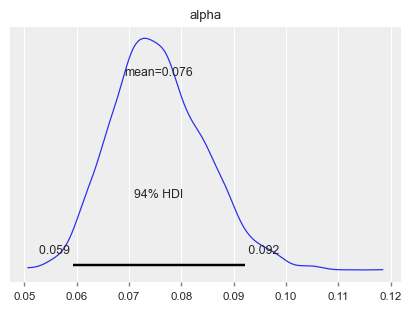

In [88]:
# Plotting posterior plots with appropriate size
az.plot_posterior(np.exp(idata.posterior), var_names=["intercept", "slopes"], figsize=(12, 3))
az.plot_posterior(idata, var_names=["alpha"], figsize=(4, 3))

array([<Axes: title={'center': 'slopes\nged_sb_tlag_1'}>,
       <Axes: title={'center': 'slopes\nged_sb_tsum_24'}>,
       <Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'alpha'}>], dtype=object)

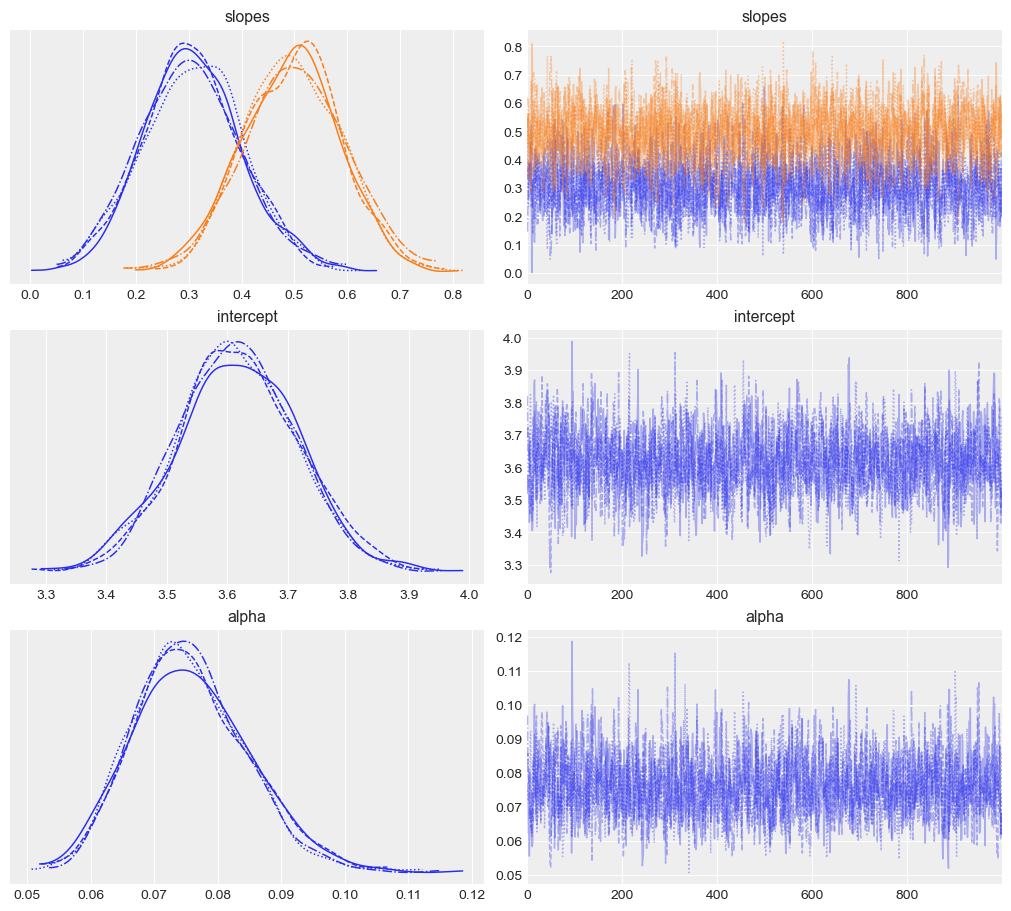

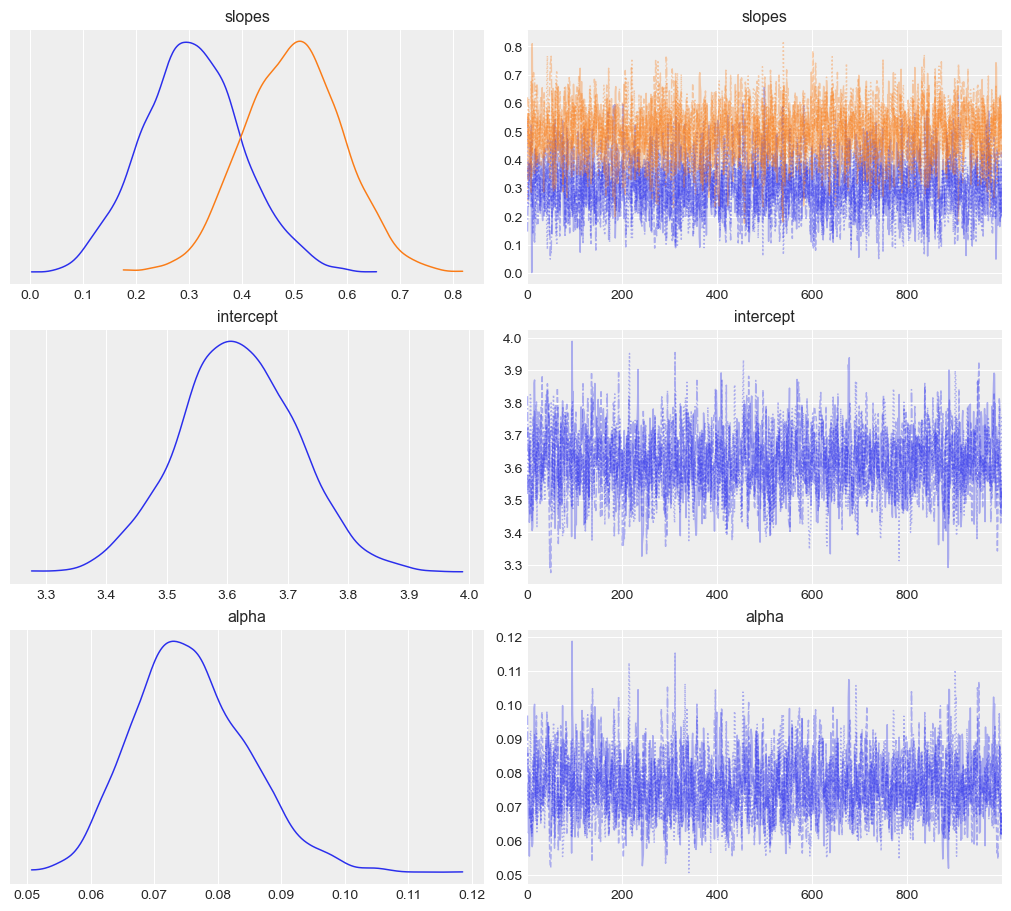

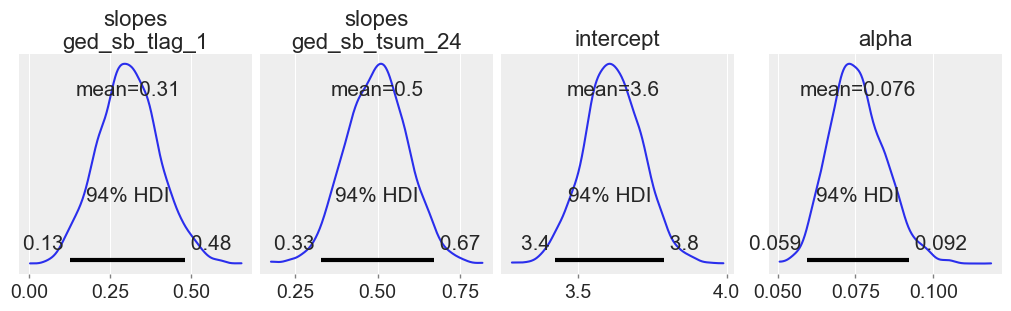

In [89]:
# Plotting trace plots in logaritmic scale
az.plot_trace(idata, figsize=(10, 9))
az.plot_trace(idata, combined=True, figsize=(10, 9))
az.plot_posterior(idata, figsize=(10, 3))

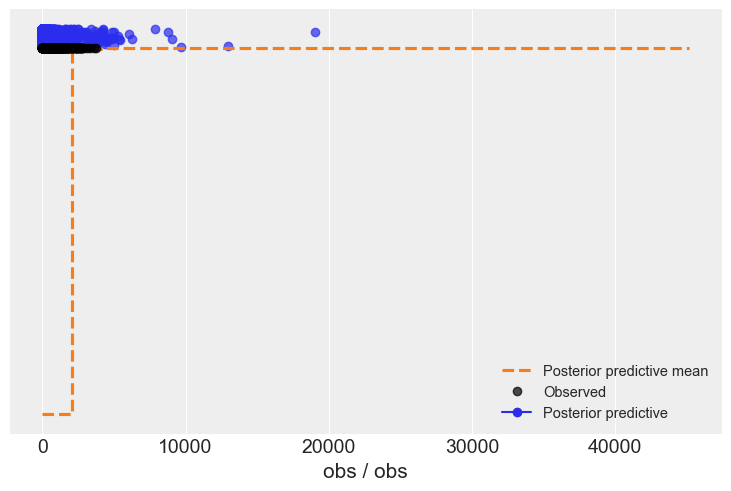

In [90]:
try:
    az.plot_ppc(idata, num_pp_samples=50, kind="scatter")
except Exception as error:
    print("Error", error)

**Summary Statistics**

In [91]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior), kind="stats", var_names=["intercept", "slopes"])

mean     sd  hdi_3%  hdi_97%
intercept               37.391  3.680  30.665   44.238
slopes[ged_sb_tlag_1]    1.364  0.129   1.121    1.602
slopes[ged_sb_tsum_24]   1.651  0.153   1.378    1.944

In [92]:
az.summary(idata.posterior, kind="stats", var_names="alpha")

mean     sd  hdi_3%  hdi_97%
alpha  0.076  0.009   0.059    0.092

**CRPS evaluation**

In [127]:
# Calculate CRPS for posterior predictive
crps_nb_gamma, crps_average_nb_gamma = calculate_crps(idata, actuals=y); crps_nb_gamma

0
0      0.007299
1      0.006740
2      0.003953
3      0.006596
4      0.005818
..          ...
365  200.053026
366  224.791553
367  126.404355
368  115.793007
369  176.225552

[370 rows x 1 columns]

### Model with Gaussian distribution for likelihood

In [94]:
# Specify which model should be examined
model = bayesian_model_gauss
idata = idata_bayesian_gauss

**Visualisations**

array([<Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'slopes\nged_sb_tlag_1'}>,
       <Axes: title={'center': 'slopes\nged_sb_tsum_24'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

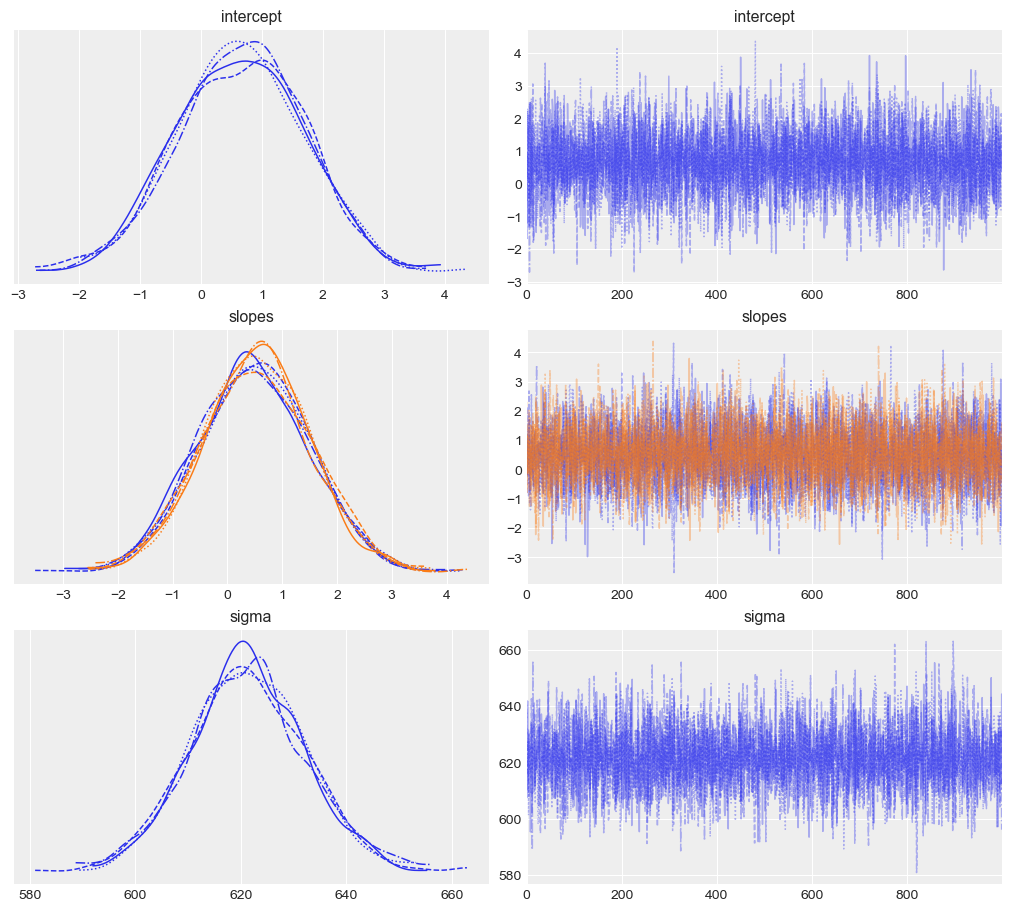

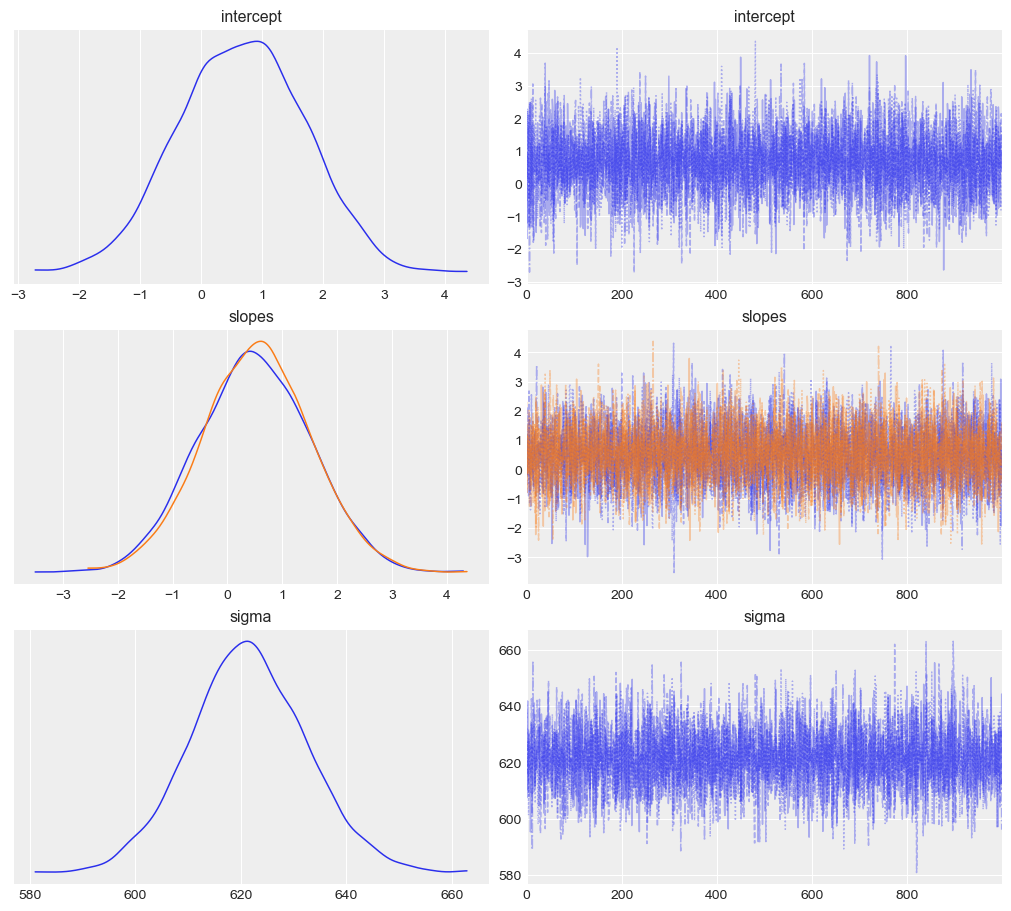

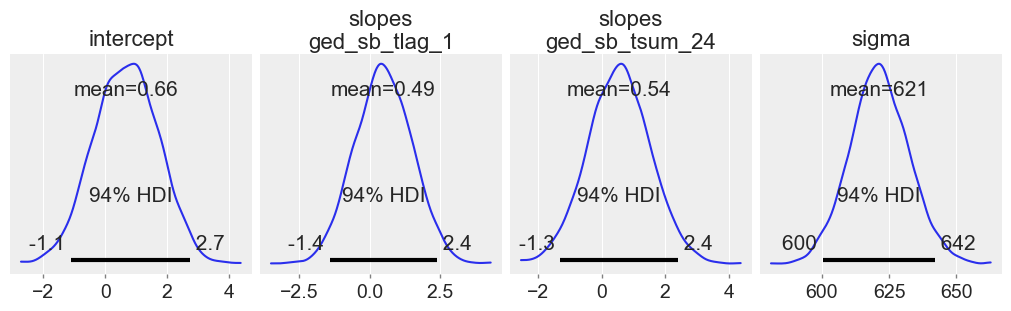

In [95]:
az.plot_trace(idata, figsize=(10, 9))
az.plot_trace(idata, combined=True, figsize=(10, 9))
az.plot_posterior(idata, figsize=(10, 3))

<Axes: xlabel='obs / obs'>

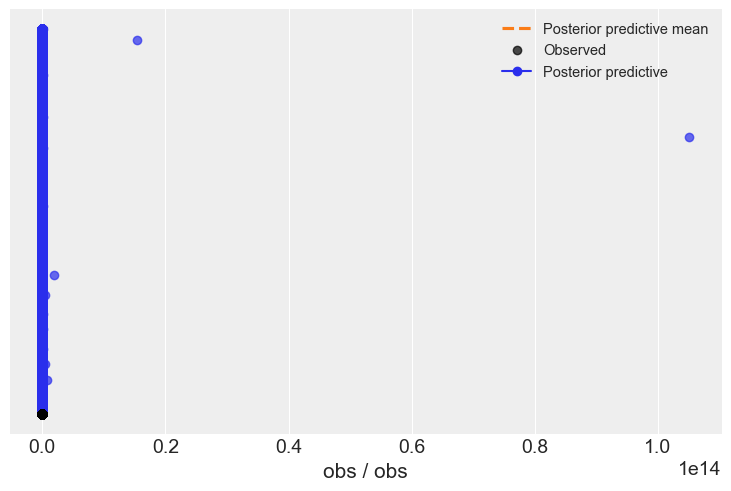

In [129]:
az.plot_ppc(idata, num_pp_samples=100, kind="scatter")

**Summary Statistics**

In [97]:
az.summary(idata.posterior, kind="stats", var_names=["intercept", "slopes"])

mean     sd  hdi_3%  hdi_97%
intercept               0.662  1.030  -1.106    2.716
slopes[ged_sb_tlag_1]   0.486  1.020  -1.416    2.388
slopes[ged_sb_tsum_24]  0.536  0.985  -1.306    2.403

In [98]:
az.summary(idata.posterior, kind="stats", var_names="sigma")

mean      sd   hdi_3%  hdi_97%
sigma  621.366  10.977  600.278  642.148

**CRPS evaluation**

In [99]:
# Calculate CRPS for posterior predictive
crps_gauss, crps_average_gauss = calculate_crps(idata, actuals=y)

## V. Test functionalities with simulated data

In [100]:
N = 100

true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

outcome = rng.normal(loc=true_mu, scale=true_sd, size=N)

In [101]:
predictor_scaled = standardize_series(predictor)
outcome_scaled = standardize_series(outcome)

In [102]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 38 seconds.


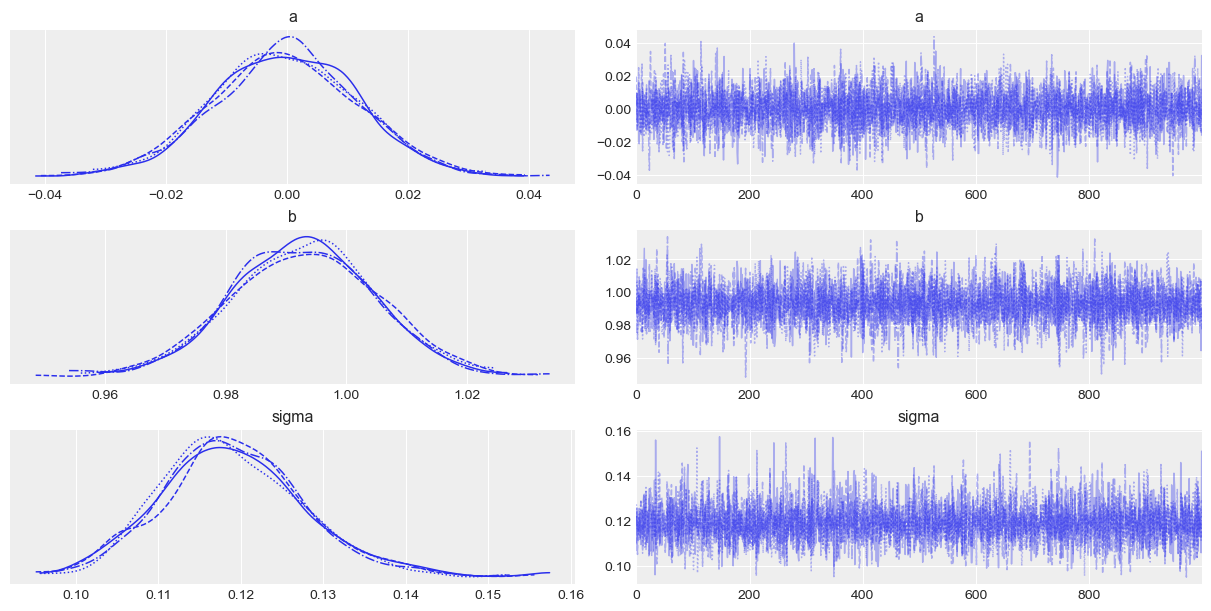

In [103]:
with model_1:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

az.plot_trace(idata);

In [104]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [obs]


<Axes: xlabel='obs / obs'>

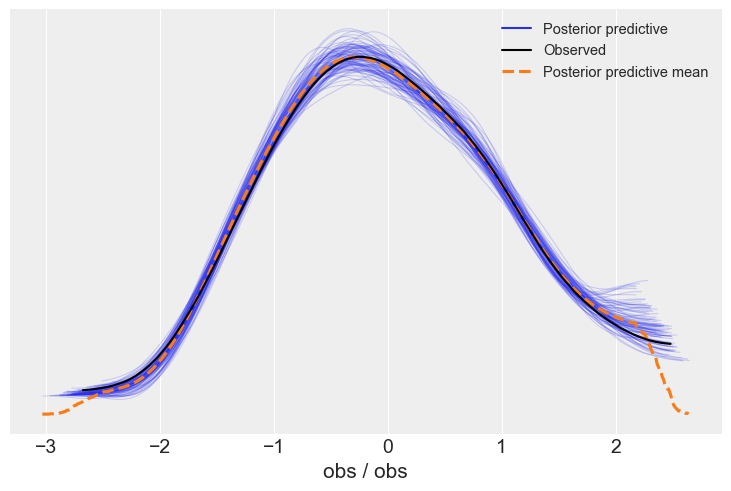

In [105]:
az.plot_ppc(idata, num_pp_samples=100)

## VI. Data exploration steps

In [106]:
df_Y_non_std_X_std

ged_sb  ged_sb_tlag_1  ged_sb_tsum_24
0       0.0      -0.878480       -0.772251
1      54.0      -0.914757       -0.768112
2     149.0      -0.842203       -0.756691
3      39.0      -0.714563       -0.753702
4       8.0      -0.862357       -0.753088
..      ...            ...             ...
365  1455.0       0.650514        2.854029
366  3115.0       1.040153        2.886606
367  1380.0       3.270496        2.808882
368  1758.0       0.939384        2.767260
369  2335.0       1.447257        2.764731

[370 rows x 3 columns]

In [107]:
pm.math.exp(pm.math.exp(2))

Exp.0

In [108]:
np.exp(np.exp(2))

1618.1779919126539

In [109]:
data_cm_features_allyears.loc[data_cm_features_allyears["country_id"] == country_id, 'ged_sb']

97          0.0
264        54.0
431       149.0
600        39.0
768         8.0
          ...  
68514    1455.0
68705    3115.0
68896    1380.0
69087    1758.0
69278    2335.0
Name: ged_sb, Length: 370, dtype: float64

<Axes: >

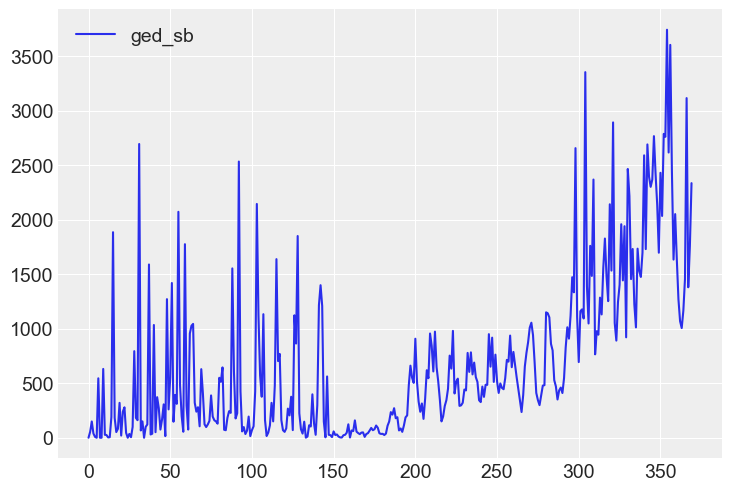

In [110]:
import seaborn as sns
sns.lineplot(y)

In [111]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -0.000  0.012  -0.023    0.022        0.0      0.0    6019.0    2636.0   
b      0.993  0.012   0.970    1.015        0.0      0.0    6100.0    2997.0   
sigma  0.119  0.009   0.103    0.136        0.0      0.0    5471.0    2926.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

In [112]:
posterior_predictive = ppc_posterior_nb_gamma.get("posterior_predicitve"); posterior_predictive

In [113]:
ppc_posterior_nb_gamma

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [114]:
posterior_predictive["obs"]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
az.plot_bpv(idata, figsize=(12, 6))

In [116]:
print(crps_average_gauss)
print(crps_average_nb)
print(crps_average_nb_gamma)

547.9187342857641
611.1761210934121
611.2531737057433


In [131]:
posterior_samples =  idata["posterior_predictive"]["obs"].values
 # Reshape the array to a 2D array with samples in rows and observations in columns
num_chains, num_draws, num_observations = posterior_samples.shape
reshaped_samples = posterior_samples.reshape(num_chains * num_draws, num_observations)

# Convert the 2D array to a pandas DataFrame
df_posterior_samples = pd.DataFrame(reshaped_samples)

# Optionally, you can add meaningful column names to the DataFrame
# For example, assuming the original DataFrame has column names 'obs_0', 'obs_1', etc.
column_names = ['obs_{}'.format(column_idx) for column_idx in range(num_observations)]
df_posterior_samples.columns = column_names